# Train model detection: Dispatch Monitoring System

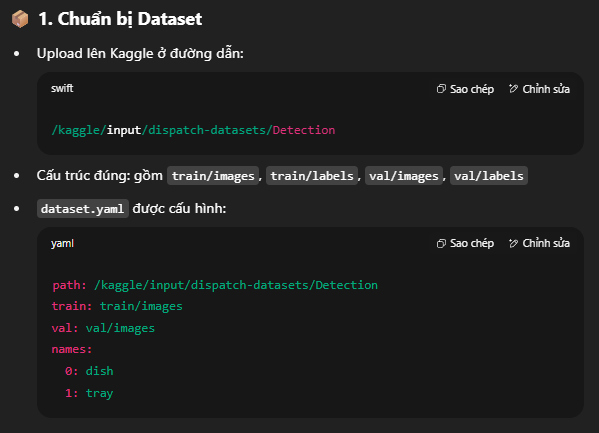

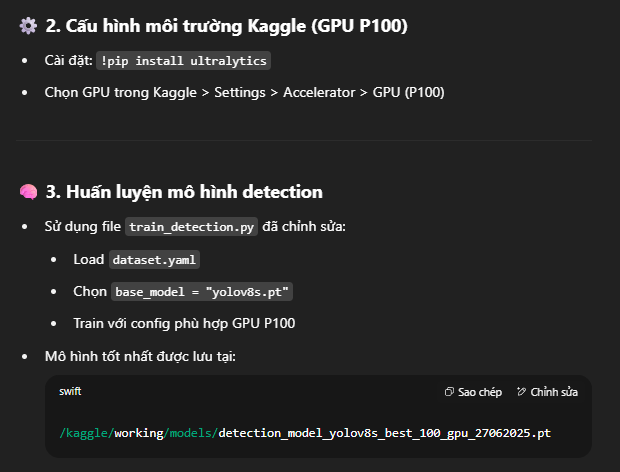

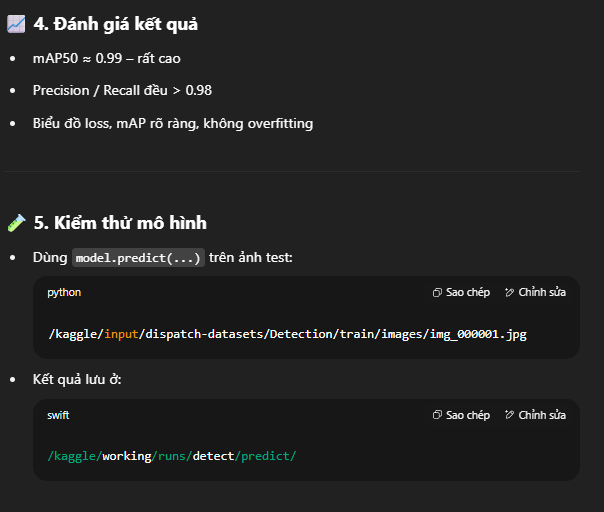

### Lưu ý sau khi chạy cell tạo file yaml xong thì lướt xuống chạy đoạn code ***merge all cells together to run***  trở đi thôi 

## Tạo file yaml 

In [2]:
yaml_path = "/kaggle/working/dataset.yaml"

yaml_content = """
train: /kaggle/input/dispatch-datasets/Detection/train/images
val: /kaggle/input/dispatch-datasets/Detection/val/images

names:
  0: dish
  1: tray

nc: 2
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())


## Kiểm tra cấu trúc thư mục

In [1]:
import os
from pathlib import Path

def check_yolo_dataset(root_dir: str):
    root = Path(root_dir)
    yaml_file = root / "dataset.yaml"
    required_dirs = [
        root / "train/images",
        root / "train/labels",
        root / "val/images",
        root / "val/labels",
    ]

    print(f"🔍 Kiểm tra dataset tại: {root_dir}\n")

    # 1. Kiểm tra file YAML
    if not yaml_file.exists():
        raise FileNotFoundError(f"❌ Không tìm thấy file YAML: {yaml_file}")
    else:
        print(f"✅ Tìm thấy file YAML: {yaml_file}")

    # 2. Kiểm tra thư mục cần thiết
    for d in required_dirs:
        if not d.exists():
            raise FileNotFoundError(f"❌ Không tìm thấy thư mục: {d}")
        else:
            print(f"✅ Tìm thấy thư mục: {d}")

    # 3. Kiểm tra khớp ảnh - label
    image_files = list((root / "train/images").glob("*.jpg"))
    label_files = list((root / "train/labels").glob("*.txt"))
    image_names = {f.stem for f in image_files}
    label_names = {f.stem for f in label_files}
    unmatched = image_names ^ label_names

    if unmatched:
        raise ValueError(f"❌ Có {len(unmatched)} file không khớp giữa ảnh và label:\n{unmatched}")
    else:
        print(f"✅ Ảnh và label khớp hoàn toàn: {len(image_files)} ảnh")

    # 4. Kiểm tra format label
    sample_labels = list((root / "train/labels").glob("*.txt"))[:5]
    for f in sample_labels:
        with open(f, "r") as file:
            lines = file.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    raise ValueError(f"❌ Lỗi định dạng trong file label: {f}")
    print("✅ Định dạng file label hợp lệ (.txt có 5 số mỗi dòng)")

    print("\n🎉 Dataset OK. Bạn có thể train YOLO!")

# Gọi hàm:
check_yolo_dataset("/kaggle/input/dispatch-datasets/Detection")


🔍 Kiểm tra dataset tại: /kaggle/input/dispatch-datasets/Detection

✅ Tìm thấy file YAML: /kaggle/input/dispatch-datasets/Detection/dataset.yaml
✅ Tìm thấy thư mục: /kaggle/input/dispatch-datasets/Detection/train/images
✅ Tìm thấy thư mục: /kaggle/input/dispatch-datasets/Detection/train/labels
✅ Tìm thấy thư mục: /kaggle/input/dispatch-datasets/Detection/val/images
✅ Tìm thấy thư mục: /kaggle/input/dispatch-datasets/Detection/val/labels
✅ Ảnh và label khớp hoàn toàn: 1040 ảnh
✅ Định dạng file label hợp lệ (.txt có 5 số mỗi dòng)

🎉 Dataset OK. Bạn có thể train YOLO!


##  Cài đặt YOLOv8

In [1]:
!pip install -q ultralytics seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00:00:0100:01


##  Import thư viện

In [3]:
import os
import time
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
class DetectionTrainer:

    def __init__(self):
        self.model = None
        self.training_results = None

        self.device = self._detect_device()
        print(f"- Training device: {self.device}")

        self.epochs = 100
        self.image_size = 640
        self.learning_rate = 0.01
        self.workers = 8
        self.patience = 50
        self.batch_size = 16 if self.device == 'cuda' else 4

        self.dataset_yaml = Path("/kaggle/working/dataset.yaml")
        self.results_dir = Path("/kaggle/working/results")
        self.models_dir = Path("/kaggle/working/models")
        self.base_model = "yolov8s.pt"

        self.results_dir.mkdir(parents=True, exist_ok=True)
        self.models_dir.mkdir(parents=True, exist_ok=True)

    def _detect_device(self):
        if torch.cuda.is_available():
            print(f"- CUDA available: {torch.cuda.device_count()} GPU(s)")
            print(f"  GPU: {torch.cuda.get_device_name(0)}")
            return "cuda"
        else:
            print("- CUDA not available. Using CPU.")
            return "cpu"

    def generate_model_name(self):
        base = Path(self.base_model).stem
        date = datetime.now().strftime("%d%m%Y")
        suffix = "gpu" if self.device == "cuda" else "cpu"
        return f"detection_model_{base}_best_{self.epochs}_{suffix}_{date}"

    def initialize_model(self):
        print(f"- Initializing model: {self.base_model}")
        self.model = YOLO(self.base_model)

    def train(self, resume=False):
        if self.model is None:
            self.initialize_model()

        model_name = self.generate_model_name()
        train_args = {
            'data': str(self.dataset_yaml),
            'epochs': self.epochs,
            'imgsz': self.image_size,
            'batch': self.batch_size,
            'lr0': self.learning_rate,
            'device': self.device,
            'workers': self.workers,
            'patience': self.patience,
            'project': str(self.results_dir),
            'name': model_name,
            'exist_ok': True,
            'pretrained': True,
            'verbose': True,
            'seed': 42,
            'resume': resume,
        }

        print("- Starting training...")
        start_time = time.time()
        self.training_results = self.model.train(**train_args)
        training_time = time.time() - start_time
        print(f"- Training done in {training_time:.2f} seconds")

        self.save_best_model()
        return self.generate_training_report(training_time)

    def save_best_model(self):
        best_model_path = self.training_results.save_dir / "weights" / "best.pt"
        if best_model_path.exists():
            model_name = self.generate_model_name() + ".pt"
            shutil.copy2(best_model_path, self.models_dir / model_name)
            print(f"✅ Best model saved to: {self.models_dir / model_name}")
        else:
            print("⚠️ Best model not found.")

    def generate_training_report(self, training_time):
        results_csv = self.training_results.save_dir / "results.csv"
        if not results_csv.exists():
            return {"status": "no results.csv", "training_time": training_time}

        df = pd.read_csv(results_csv)
        best_epoch = df['metrics/mAP50(B)'].idxmax()
        best = df.iloc[best_epoch]

        self.plot_results(df)

        return {
            "training_time": training_time,
            "total_epochs": len(df),
            "best_epoch": best_epoch + 1,
            "mAP50": best['metrics/mAP50(B)'],
            "mAP50-95": best.get('metrics/mAP50-95(B)', 0),
            "precision": best['metrics/precision(B)'],
            "recall": best['metrics/recall(B)'],
        }

    def plot_results(self, df):
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        axs[0, 0].plot(df['train/box_loss'], label='Train Box Loss')
        axs[0, 0].plot(df['val/box_loss'], label='Val Box Loss')
        axs[0, 0].set_title('Box Loss')
        axs[0, 0].legend()

        axs[0, 1].plot(df['metrics/mAP50(B)'], label='mAP50')
        axs[0, 1].plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
        axs[0, 1].set_title('mAP')
        axs[0, 1].legend()

        axs[1, 0].plot(df['metrics/precision(B)'], label='Precision')
        axs[1, 0].plot(df['metrics/recall(B)'], label='Recall')
        axs[1, 0].set_title('Precision & Recall')
        axs[1, 0].legend()

        if 'lr/pg0' in df.columns:
            axs[1, 1].plot(df['lr/pg0'], label='Learning Rate')
            axs[1, 1].set_title('Learning Rate')
            axs[1, 1].legend()
        else:
            axs[1, 1].text(0.5, 0.5, 'No learning rate data', ha='center', va='center')

        plt.tight_layout()
        plt.savefig(self.results_dir / "results_plot.png", dpi=300)
        print("📊 Plot saved.")


In [ ]:
trainer = DetectionTrainer()
results = trainer.train()

- CUDA available: 1 GPU(s)
  GPU: Tesla P100-PCIE-16GB
- Training device: cuda
- Initializing model: yolov8s.pt


100%|██████████| 21.5M/21.5M [00:00<00:00, 33.0MB/s]


- Starting training...
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detection_model_yolov8s_best_100_gpu_27062025, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

100%|██████████| 755k/755k [00:00<00:00, 3.79MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.1±4.4 MB/s, size: 39.0 KB)


train: Scanning /kaggle/input/dispatch-datasets/Detection/train/labels... 1040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:02<00:00, 377.06it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dispatch-datasets/Detection/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 12.9±4.7 MB/s, size: 39.7 KB)


val: Scanning /kaggle/input/dispatch-datasets/Detection/val/labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<00:00, 282.97it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dispatch-datasets/Detection/val is not writeable, cache not saved.


Plotting labels to /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.32G     0.8857      1.527      1.185         50        640: 100%|██████████| 65/65 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all        261        374      0.858      0.887      0.924      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.36G     0.8616     0.8732      1.126         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

                   all        261        374      0.688      0.794       0.84      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.39G     0.8778     0.8042       1.14         56        640: 100%|██████████| 65/65 [00:19<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        261        374       0.58      0.751      0.695      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.43G     0.8593      0.809      1.128         44        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        261        374      0.861      0.924      0.944      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.47G     0.8209     0.7156      1.099         57        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261        374      0.898      0.896      0.955      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       4.5G      0.797     0.6492      1.099         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261        374      0.939      0.963      0.979      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.54G     0.7872     0.6591      1.084         52        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]

                   all        261        374      0.916      0.936      0.968      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.57G     0.7558     0.6296      1.078         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        261        374      0.975      0.965      0.986      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.61G      0.745     0.6281      1.083         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261        374      0.961      0.948      0.979      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.65G     0.7251     0.5793      1.064         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        261        374      0.928      0.941      0.966      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.69G      0.733     0.5833      1.065         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        261        374      0.855      0.866      0.958      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.72G     0.7382     0.5754      1.068         35        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261        374      0.959      0.968      0.984      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.76G     0.6977     0.5628      1.056         33        640: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261        374      0.984      0.971      0.992      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.79G     0.7126     0.5334      1.044         51        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261        374      0.984      0.967       0.99      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.83G      0.694     0.5327      1.044         44        640: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        261        374      0.994      0.966      0.988       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.87G     0.6785     0.5111      1.042         45        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        261        374      0.969      0.978      0.989       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       4.9G     0.6703     0.5108      1.042         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261        374      0.942      0.925      0.982       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.94G     0.6354     0.4761      1.016         48        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.989      0.964      0.987      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.97G     0.6406      0.481      1.017         49        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

                   all        261        374      0.976      0.967      0.979      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.01G      0.645     0.4781      1.017         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374       0.99      0.983      0.989      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.05G     0.6419     0.4746      1.017         49        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261        374      0.984      0.973      0.988       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.08G      0.642     0.4525      1.007         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374       0.98      0.974      0.989      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.12G     0.6335     0.4462      1.007         40        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.981      0.974      0.988      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.16G     0.6024      0.436     0.9983         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.991      0.971      0.994      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.19G     0.6178     0.4442       1.01         45        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261        374      0.988      0.971      0.986      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.23G     0.6261     0.4529      1.016         32        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

                   all        261        374      0.981      0.973      0.984      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.27G     0.6393     0.4462      1.015         33        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        261        374      0.987       0.98      0.992      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       5.3G     0.6161     0.4311     0.9999         52        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        261        374      0.981      0.971      0.987      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.34G     0.6241      0.445      1.015         54        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.18it/s]

                   all        261        374      0.996      0.976      0.993      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.38G     0.6014     0.4242          1         38        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261        374       0.96      0.964      0.987      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.41G     0.5942     0.4254     0.9925         39        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261        374       0.99      0.982      0.987      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.67G     0.5807      0.397     0.9937         39        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261        374      0.997      0.978       0.99      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.71G     0.5929     0.3973     0.9987         40        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.998      0.973       0.99      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.74G     0.5847     0.3976     0.9959         41        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261        374       0.98      0.969      0.987       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.78G     0.5776     0.4048     0.9879         33        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.979      0.971      0.991      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.81G     0.5753     0.3925      0.987         43        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261        374      0.983      0.974      0.983      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.85G     0.5666     0.3818     0.9726         51        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261        374      0.982      0.975      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.89G     0.5759     0.3965     0.9858         49        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.986      0.977      0.993      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.92G     0.5952     0.4039      1.009         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261        374      0.996      0.973      0.994      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.18G     0.5755     0.3852     0.9895         28        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261        374      0.981      0.976       0.99      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.22G     0.5755     0.3881     0.9905         51        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.987      0.977      0.992      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.26G     0.5559     0.3697     0.9833         34        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

                   all        261        374      0.973      0.973      0.988      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.29G     0.5352     0.3543     0.9638         44        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

                   all        261        374      0.987      0.981      0.987      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.33G     0.5597     0.3725     0.9711         32        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261        374      0.991      0.982      0.991      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.37G     0.5547     0.3679      0.969         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261        374      0.984      0.984      0.988      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.4G     0.5495     0.3659     0.9751         58        640: 100%|██████████| 65/65 [00:19<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        261        374      0.993      0.972      0.987      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.44G     0.5395     0.3629     0.9691         39        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261        374      0.988      0.981       0.99      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       6.7G     0.5277     0.3416     0.9674         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        261        374      0.987       0.97       0.99      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.73G     0.5376     0.3576     0.9716         56        640: 100%|██████████| 65/65 [00:19<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        261        374      0.972      0.977      0.989      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.77G     0.5411      0.357      0.984         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261        374      0.989      0.975       0.99      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       6.8G     0.5385     0.3518     0.9754         34        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        261        374      0.995      0.967       0.99      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.84G     0.5341     0.3504     0.9686         44        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        261        374      0.995      0.986      0.991      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.88G     0.5361     0.3393     0.9704         36        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261        374      0.985       0.99      0.991      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.91G     0.5386     0.3426     0.9758         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        261        374      0.997      0.976       0.99      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.95G     0.5249     0.3397     0.9702         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]

                   all        261        374      0.986      0.984       0.99       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.21G     0.5201     0.3395     0.9721         45        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261        374      0.991      0.981      0.989      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      7.25G     0.5268     0.3331     0.9649         36        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        261        374      0.983       0.97      0.989      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      7.28G     0.5157     0.3302     0.9638         37        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261        374      0.986      0.985      0.988      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      7.32G     0.5221     0.3314     0.9583         36        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        261        374      0.997      0.977      0.989      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      7.36G     0.5108      0.325     0.9533         36        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261        374       0.99      0.986       0.99      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.39G     0.5129     0.3329      0.964         63        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.991      0.979      0.989      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.43G     0.5179     0.3155      0.968         49        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261        374      0.997       0.98       0.99      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.46G     0.4965     0.3144     0.9617         59        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374       0.99      0.984       0.99      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.72G     0.5125     0.3252     0.9625         40        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261        374      0.991      0.986      0.991      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.76G     0.5021     0.3163     0.9544         35        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.987      0.987      0.989      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       7.8G     0.4986     0.3151      0.957         47        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

                   all        261        374      0.994      0.978      0.991      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.83G     0.4937     0.3097     0.9489         49        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        261        374      0.992      0.984       0.99       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.87G     0.4979     0.3082     0.9642         58        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.992      0.983      0.991      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.91G     0.4912     0.3031     0.9475         33        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]

                   all        261        374      0.997      0.979       0.99      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.94G     0.4932     0.3043     0.9392         32        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        261        374      0.989      0.984       0.99       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.57G     0.4804     0.2935     0.9443         41        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        261        374      0.991      0.982      0.989      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.57G     0.4975      0.307     0.9486         63        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261        374      0.996      0.982      0.988      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.57G     0.4834     0.2985      0.939         33        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.994      0.982      0.991      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.57G     0.4955     0.3012     0.9595         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.50it/s]

                   all        261        374      0.996      0.984      0.991      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.57G     0.4821     0.3027     0.9484         41        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

                   all        261        374      0.991      0.987       0.99      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.57G     0.4844     0.2975     0.9441         35        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.989      0.986       0.99      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.57G     0.4727     0.2827     0.9332         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.988      0.987      0.991      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.57G     0.4705     0.2877     0.9397         44        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.992       0.98      0.991      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       4.6G     0.4669     0.2831     0.9396         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

                   all        261        374      0.992      0.986      0.992      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.63G     0.4596     0.2768       0.93         55        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]

                   all        261        374      0.992      0.989      0.991      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.67G     0.4569     0.2813     0.9276         50        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.991      0.987      0.991      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.71G     0.4664     0.2856     0.9308         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        261        374      0.994      0.981      0.989      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.74G     0.4695     0.2779     0.9377         46        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        261        374      0.994      0.984      0.991      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.78G     0.4601     0.2751     0.9351         35        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261        374      0.993      0.979      0.991      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.81G     0.4533     0.2718     0.9363         38        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.988      0.987      0.991       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.85G     0.4506     0.2664     0.9326         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        261        374      0.988      0.987      0.991      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.89G     0.4526     0.2724     0.9279         59        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261        374      0.988      0.984      0.991      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.92G      0.454     0.2712     0.9344         39        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.992      0.981      0.991      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.96G     0.4428     0.2622     0.9292         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.989      0.983      0.991      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         5G     0.4447     0.2571     0.9304         42        640: 100%|██████████| 65/65 [00:19<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261        374      0.993      0.982      0.991       0.92


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.03G     0.3691     0.2148       0.88         19        640: 100%|██████████| 65/65 [00:20<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

                   all        261        374      0.995      0.979      0.991      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.07G     0.3643     0.2092     0.8776         24        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.994      0.982      0.991      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       5.1G     0.3613     0.2105     0.8764         22        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261        374      0.995      0.983      0.991      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.14G     0.3648      0.209     0.8798         24        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261        374      0.994      0.984      0.991      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.18G     0.3515     0.2029     0.8683         31        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261        374      0.993      0.984      0.991      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.21G     0.3433      0.201     0.8649         30        640: 100%|██████████| 65/65 [00:19<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]

                   all        261        374      0.993      0.984      0.991      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.25G     0.3462     0.2003     0.8667         21        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261        374      0.992      0.983      0.991      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.29G     0.3491     0.2016     0.8764         29        640: 100%|██████████| 65/65 [00:19<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261        374      0.988      0.987      0.991      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.32G     0.3432     0.1998     0.8673         28        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261        374      0.988      0.987      0.991      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.36G     0.3427     0.1967     0.8731         23        640: 100%|██████████| 65/65 [00:19<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.46it/s]

                   all        261        374      0.989      0.987      0.991      0.926



100 epochs completed in 0.608 hours.
Optimizer stripped from /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025/weights/best.pt, 22.5MB

Validating /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.19it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        261        374      0.988      0.987      0.991      0.927
                  dish        131        175      0.997      0.989      0.995      0.933
                  tray        180        199      0.979      0.985      0.988      0.921
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /kaggle/working/results/detection_model_yolov8s_best_100_gpu_27062025
- Training done in 2218.40 seconds
✅ Best model saved to: /kaggle/working/models/detection_model_yolov8s_best_100_gpu_27062025.pt
📊 Plot saved.


## Nén mô hình và tải về

In [10]:
import os
import shutil

# Thư mục tạm chứa các file cần zip
temp_dir = "/kaggle/temp_output"
os.makedirs(temp_dir, exist_ok=True)

# Copy mọi thứ từ /kaggle/working (không zip)
for item in os.listdir("/kaggle/working"):
    src = os.path.join("/kaggle/working", item)
    dst = os.path.join(temp_dir, item)
    if os.path.isdir(src):
        shutil.copytree(src, dst)
    else:
        shutil.copy2(src, dst)


In [11]:
shutil.make_archive("full_training_output", "zip", temp_dir)

from IPython.display import FileLink
print("📦 Hoàn tất nén toàn bộ output. Tải về tại đây:")
FileLink("full_training_output.zip")


📦 Hoàn tất nén toàn bộ output. Tải về tại đây:


/kaggle/working/full_training_output.zip

## test model detection

In [18]:
from ultralytics import YOLO

# Load mô hình YOLOv8 đã huấn luyện
model_path = "/kaggle/working/models/detection_model_yolov8s_best_100_gpu_27062025.pt"
model = YOLO(model_path)

print("✅ Mô hình đã sẵn sàng để dự đoán.")


✅ Mô hình đã sẵn sàng để dự đoán.


In [22]:
# Đường dẫn tới ảnh cần test
image_path = "/kaggle/input/dispatch-datasets/Detection/val/images/img_000091.jpg"

In [23]:
# Chạy dự đoán và lưu ảnh kết quả vào thư mục cố định
results = model.predict(
    source=image_path,
    save=True,
    conf=0.25,  # confidence threshold
    project='runs/detect',
    name='predict',
    exist_ok=True  # không tạo predict2, predict3,...
)



image 1/1 /kaggle/input/dispatch-datasets/Detection/val/images/img_000091.jpg: 640x640 1 tray, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


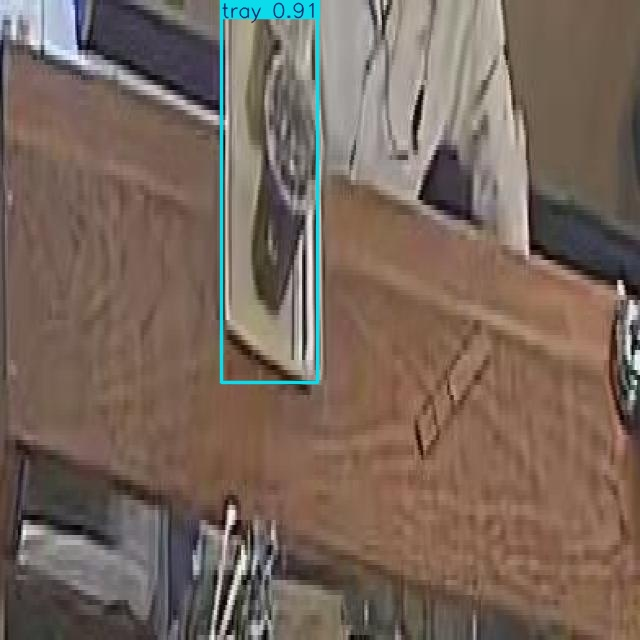

In [24]:
from pathlib import Path
from IPython.display import Image, display
import os

# Xác định đường dẫn ảnh đã lưu sau khi predict
output_image_path = Path(results[0].save_dir) / os.path.basename(image_path)

# Hiển thị ảnh
display(Image(filename=str(output_image_path)))


# Train model classification: Dispatch Monitoring System

In [3]:
import os
import sys
import time
from pathlib import Path
from datetime import datetime
from typing import Dict
import shutil

import torch
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

class ClassificationTrainer:   
    def __init__(self):
        self.model = None
        self.training_results = None
        self.class_names = []
        
        self.device = self._detect_device()
        print(f"- Training device: {self.device}")
        
        self.epochs = 100
        self.learning_rate = 0.001
        self.patience = 50
        
        if self.device == 'cpu':
            self.batch_size = 8
            self.image_size = 224
            self.workers = min(4, os.cpu_count())
        else:
            self.batch_size = 16
            self.image_size = 224
            self.workers = 8
        
        self.dataset_root = Path("/kaggle/input/data-classificate/Classification")
        self.results_dir = Path("/kaggle/working/results")
        self.models_dir = Path("/kaggle/working/models")
        self.base_model = "yolov8s-cls.pt"
        
        self.validate_environment()
        self.prepare_dataset()

    def _detect_device(self):
        if torch.cuda.is_available():
            print(f"- CUDA available: {torch.cuda.get_device_name(0)}")
            return 'cuda'
        return 'cpu'

    def generate_model_name(self) -> str:
        base_name = Path(self.base_model).stem
        current_date = datetime.now().strftime("%d%m%Y")
        device_suffix = "gpu" if self.device == 'cuda' else "cpu"
        return f"classification_model_{base_name}_best_{self.epochs}_{device_suffix}_{current_date}"

    def validate_environment(self):
        print("- Validating classification training environment...")
        if not self.dataset_root.exists():
            raise FileNotFoundError(f"Dataset root not found: {self.dataset_root}")
        print("- Dataset found!")
        print("- Environment validation completed")

    def prepare_dataset(self):
        print("📂 Preparing classification dataset...")
        yolo_dataset_dir = self.results_dir / "classification_dataset"
        
        all_classes = set()
        for category in ['dish', 'tray']:
            category_path = self.dataset_root / category
            if category_path.exists():
                for class_dir in category_path.iterdir():
                    if class_dir.is_dir():
                        all_classes.add(f"{category}_{class_dir.name}")
        
        self.class_names = sorted(list(all_classes))
        print(f"🏷️ Detected classes: {self.class_names}")
        
        for split in ['train', 'val']:
            for cls in self.class_names:
                (yolo_dataset_dir / split / cls).mkdir(parents=True, exist_ok=True)

        split_ratio = 0.8
        for category in ['dish', 'tray']:
            category_path = self.dataset_root / category
            for class_dir in category_path.iterdir():
                if not class_dir.is_dir(): continue
                combined_class = f"{category}_{class_dir.name}"
                images = list(class_dir.glob('*'))
                np.random.seed(42)
                np.random.shuffle(images)
                split_idx = int(len(images) * split_ratio)
                for imgs, split in [(images[:split_idx], 'train'), (images[split_idx:], 'val')]:
                    for img in imgs:
                        shutil.copy2(img, yolo_dataset_dir / split / combined_class / img.name)
        self.prepared_dataset_path = yolo_dataset_dir
        print(f"✅ Dataset prepared at: {self.prepared_dataset_path}")

    def initialize_model(self):
        print(f"- Initializing {self.base_model} classification model...")
        self.model = YOLO(self.base_model)
        print("- Model initialized successfully")

    def train(self, resume: bool = False) -> Dict:
        print("- Starting classification model training...")
        if self.model is None:
            self.initialize_model()
        
        model_name = self.generate_model_name()
        train_args = {
            'data': str(self.prepared_dataset_path),
            'epochs': self.epochs,
            'imgsz': self.image_size,
            'batch': self.batch_size,
            'lr0': self.learning_rate,
            'device': self.device,
            'workers': self.workers,
            'patience': self.patience,
            'project': str(self.results_dir),
            'name': model_name,
            'exist_ok': True,
            'pretrained': True,
            'verbose': True,
            'seed': 42,
            'resume': resume,
        }
        print("- Training config:", train_args)
        start_time = time.time()
        self.training_results = self.model.train(**train_args)
        print(f"- Training done in {time.time() - start_time:.2f}s")
        self.save_best_model()
        return {"model_name": model_name}

    def save_best_model(self):
        best_model_path = self.training_results.save_dir / "weights" / "best.pt"
        if best_model_path.exists():
            self.models_dir.mkdir(exist_ok=True)
            final_path = self.models_dir / f"{self.generate_model_name()}.pt"
            shutil.copy2(best_model_path, final_path)
            print(f"✅ Best model saved to: {final_path}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
trainer = ClassificationTrainer()
results = trainer.train()

print(f"\n🎯 Done training classification! Best model: {results['model_name']}.pt")


- CUDA available: Tesla P100-PCIE-16GB
- Training device: cuda
- Validating classification training environment...
- Dataset found!
- Environment validation completed
📂 Preparing classification dataset...
🏷️ Detected classes: ['dish_empty', 'dish_kakigori', 'dish_not_empty', 'tray_empty', 'tray_kakigori', 'tray_not_empty']
✅ Dataset prepared at: /kaggle/working/results/classification_dataset
- Starting classification model training...
- Initializing yolov8s-cls.pt classification model...


100%|██████████| 12.3M/12.3M [00:00<00:00, 96.8MB/s]


- Model initialized successfully
- Training config: {'data': '/kaggle/working/results/classification_dataset', 'epochs': 100, 'imgsz': 224, 'batch': 16, 'lr0': 0.001, 'device': 'cuda', 'workers': 8, 'patience': 50, 'project': '/kaggle/working/results', 'name': 'classification_model_yolov8s-cls_best_100_gpu_28062025', 'exist_ok': True, 'pretrained': True, 'verbose': True, 'seed': 42, 'resume': False}
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/results/classification_dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=

100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 205.7±71.7 MB/s, size: 5.6 KB)


train: Scanning /kaggle/working/results/classification_dataset/train... 2329 images, 0 corrupt: 100%|██████████| 2329/2329 [00:00<00:00, 3051.66it/s]

train: New cache created: /kaggle/working/results/classification_dataset/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 205.1±94.5 MB/s, size: 6.9 KB)


val: Scanning /kaggle/working/results/classification_dataset/val... 585 images, 0 corrupt: 100%|██████████| 585/585 [00:00<00:00, 3231.38it/s]


val: New cache created: /kaggle/working/results/classification_dataset/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 4 dataloader workers
Logging results to /kaggle/working/results/classification_model_yolov8s-cls_best_100_gpu_28062025
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.559G      1.856         16        224:   4%|▍         | 6/146 [00:01<00:16,  8.48it/s]

      1/100     0.559G      1.837         16        224:  10%|█         | 15/146 [00:01<00:07, 16.47it/s]
100%|██████████| 755k/755k [00:00<00:00, 26.9MB/s]
      1/100     0.568G      1.238          9        224: 100%|██████████| 146/146 [00:07<00:00, 19.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 22.52it/s]

                   all      0.803          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.582G     0.5025          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.56it/s]

                   all      0.868      0.998



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.598G     0.3711          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.89it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.605G     0.3817          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.67it/s]

                   all      0.897          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.699G     0.2893          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 30.47it/s]

                   all      0.884          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.707G     0.2446          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.57it/s]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.723G     0.2391          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.75it/s]

                   all      0.911      0.997



      Epoch    GPU_mem       loss  Instances       Size


      8/100      0.73G     0.2182          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.39it/s]

                   all      0.892          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.746G     0.1938          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.64it/s]

                   all      0.874          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.832G     0.1749          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.72it/s]

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.848G     0.1515          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.59it/s]

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.855G     0.1507          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.69it/s]

                   all      0.885          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.871G     0.1445          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.61it/s]

                   all      0.904      0.998



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.957G      0.134          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.08it/s]

                   all      0.894      0.998



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.973G     0.1067          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.15it/s]

                   all      0.908      0.998



      Epoch    GPU_mem       loss  Instances       Size


     16/100      0.98G     0.1366          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.36it/s]

                   all      0.911          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.996G     0.1074          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.45it/s]

                   all       0.92      0.998



      Epoch    GPU_mem       loss  Instances       Size


     18/100      1.08G     0.1074          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.02it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100       1.1G    0.09848          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.30it/s]

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      1.11G     0.1063          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.83it/s]

                   all      0.921      0.998



      Epoch    GPU_mem       loss  Instances       Size


     21/100      1.12G    0.09014          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 20.42it/s]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      1.21G    0.09995          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.16it/s]

                   all      0.935      0.998



      Epoch    GPU_mem       loss  Instances       Size


     23/100      1.22G    0.08156          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.28it/s]

                   all      0.921      0.998



      Epoch    GPU_mem       loss  Instances       Size


     24/100      1.23G    0.09371          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.18it/s]

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      1.25G    0.07511          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 19.37it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      1.33G    0.07147          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.49it/s]

                   all      0.909      0.998



      Epoch    GPU_mem       loss  Instances       Size


     27/100      1.35G    0.08308          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.60it/s]

                   all       0.93      0.998



      Epoch    GPU_mem       loss  Instances       Size


     28/100      1.36G    0.06132          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 30.31it/s]

                   all      0.935      0.998



      Epoch    GPU_mem       loss  Instances       Size


     29/100      1.37G    0.08004          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.13it/s]

                   all      0.915          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      1.46G    0.06894          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.95it/s]

                   all      0.932      0.998



      Epoch    GPU_mem       loss  Instances       Size


     31/100      1.47G    0.06408          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.20it/s]

                   all      0.915          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      1.48G    0.06306          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.58it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      1.49G    0.06552          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.56it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100      1.58G    0.06552          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.23it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100       1.6G    0.06658          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.38it/s]

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100      1.61G    0.05795          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.94it/s]

                   all      0.921          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100      1.62G    0.04756          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.54it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100      1.71G    0.05583          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.02it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100      1.72G    0.05205          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.91it/s]

                   all      0.915          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100      1.73G    0.04401          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.75it/s]

                   all      0.944      0.998



      Epoch    GPU_mem       loss  Instances       Size


     41/100      1.74G    0.03836          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 30.38it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100      1.75G    0.04254          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 22.80it/s]

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100      1.85G    0.04738          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.90it/s]

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100      1.85G    0.04818          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.60it/s]

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100      1.87G    0.03918          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.05it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100      1.96G    0.04387          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 30.04it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100      1.97G     0.0468          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 25.61it/s]

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100      1.98G    0.04158          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.46it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100      1.99G    0.03194          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.61it/s]

                   all      0.928      0.998



      Epoch    GPU_mem       loss  Instances       Size


     50/100         2G    0.02867          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.17it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100       2.1G    0.03332          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.21it/s]

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100       2.1G    0.04529          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.67it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100      2.12G     0.0483          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.96it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100      2.21G    0.03266          9        224: 100%|██████████| 146/146 [00:06<00:00, 23.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.55it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100      2.22G    0.03415          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.71it/s]

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100      2.23G    0.03914          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.90it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100      2.24G    0.02529          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.41it/s]

                   all      0.928      0.998



      Epoch    GPU_mem       loss  Instances       Size


     58/100      2.25G    0.03132          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.42it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100      2.35G     0.0236          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.18it/s]

                   all      0.942      0.998



      Epoch    GPU_mem       loss  Instances       Size


     60/100      2.35G    0.03116          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.06it/s]

                   all      0.933      0.997



      Epoch    GPU_mem       loss  Instances       Size


     61/100      2.37G    0.02932          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.56it/s]

                   all      0.925      0.997



      Epoch    GPU_mem       loss  Instances       Size


     62/100      2.38G    0.03165          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.35it/s]

                   all      0.935      0.997



      Epoch    GPU_mem       loss  Instances       Size


     63/100      2.47G    0.03227          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.80it/s]

                   all      0.945      0.997



      Epoch    GPU_mem       loss  Instances       Size


     64/100      2.48G     0.0319          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.25it/s]

                   all      0.933      0.998



      Epoch    GPU_mem       loss  Instances       Size


     65/100      2.49G    0.03385          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.43it/s]


                   all      0.942      0.997

      Epoch    GPU_mem       loss  Instances       Size


     66/100      2.58G    0.02899          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.67it/s]

                   all      0.935      0.998



      Epoch    GPU_mem       loss  Instances       Size


     67/100      2.59G    0.02865          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.32it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


     68/100       2.6G    0.02068          9        224: 100%|██████████| 146/146 [00:06<00:00, 20.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.41it/s]

                   all      0.926      0.998



      Epoch    GPU_mem       loss  Instances       Size


     69/100      2.62G    0.02044          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 29.01it/s]

                   all      0.935      0.997



      Epoch    GPU_mem       loss  Instances       Size


     70/100      2.63G    0.01815          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.54it/s]

                   all      0.938      0.998



      Epoch    GPU_mem       loss  Instances       Size


     71/100      2.72G    0.01964          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.37it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


     72/100      2.73G     0.0226          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.74it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


     73/100      2.74G    0.02291          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.62it/s]

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100      2.75G    0.01811          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.42it/s]

                   all      0.938      0.998



      Epoch    GPU_mem       loss  Instances       Size


     75/100      2.84G     0.0272          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.53it/s]

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100      2.85G    0.02303          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.47it/s]

                   all      0.904      0.998



      Epoch    GPU_mem       loss  Instances       Size


     77/100      2.87G    0.01505          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.28it/s]

                   all      0.932      0.997



      Epoch    GPU_mem       loss  Instances       Size


     78/100      2.88G    0.01755          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.99it/s]

                   all      0.937      0.997



      Epoch    GPU_mem       loss  Instances       Size


     79/100      2.97G    0.01676          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.06it/s]

                   all      0.926      0.997



      Epoch    GPU_mem       loss  Instances       Size


     80/100      2.98G    0.01789          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.92it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


     81/100      2.99G    0.01687          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.14it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100         3G    0.01441          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.97it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100      3.09G    0.01364          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.53it/s]

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100       3.1G    0.01369          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 30.67it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100      3.12G    0.01486          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.48it/s]

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100      3.12G    0.01117          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.04it/s]

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100      3.22G    0.01339          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.24it/s]

                   all       0.94      0.998



      Epoch    GPU_mem       loss  Instances       Size


     88/100      3.23G     0.0154          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.40it/s]

                   all      0.938      0.998



      Epoch    GPU_mem       loss  Instances       Size


     89/100      3.24G    0.01098          9        224: 100%|██████████| 146/146 [00:07<00:00, 20.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.56it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


     90/100      3.25G    0.01343          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.65it/s]

                   all       0.95      0.998



      Epoch    GPU_mem       loss  Instances       Size


     91/100      3.27G    0.01589          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.37it/s]


                   all      0.942      0.998

      Epoch    GPU_mem       loss  Instances       Size


     92/100      3.35G    0.01815          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 26.45it/s]

                   all      0.944      0.998



      Epoch    GPU_mem       loss  Instances       Size


     93/100      3.37G   0.009819          9        224: 100%|██████████| 146/146 [00:06<00:00, 21.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 20.20it/s]

                   all      0.942      0.998



      Epoch    GPU_mem       loss  Instances       Size


     94/100      3.38G    0.01327          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 24.97it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100      3.39G    0.01422          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 28.02it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100      3.48G    0.00738          9        224: 100%|██████████| 146/146 [00:06<00:00, 22.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 27.26it/s]

                   all      0.947      0.998
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 46, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



96 epochs completed in 0.203 hours.
Optimizer stripped from /kaggle/working/results/classification_model_yolov8s-cls_best_100_gpu_28062025/weights/last.pt, 10.3MB
Optimizer stripped from /kaggle/working/results/classification_model_yolov8s-cls_best_100_gpu_28062025/weights/best.pt, 10.3MB

Validating /kaggle/working/results/classification_model_yolov8s-cls_best_100_gpu_28062025/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,082,886 parameters, 0 gradients, 12.5 GFLOPs
train: /kaggle/working/results/classification_dataset/train... found 2329 images in 6 classes ✅ 
val: /kaggle/working/results/classification_dataset/val... found 585 images in 6 classes ✅ 
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 19/19 [00:00<00:00, 21.77it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.956          1
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/results/classification_model_yolov8s-cls_best_100_gpu_28062025
- Training done in 740.19s
✅ Best model saved to: /kaggle/working/models/classification_model_yolov8s-cls_best_100_gpu_28062025.pt

🎯 Done training classification! Best model: classification_model_yolov8s-cls_best_100_gpu_28062025.pt


## Vẽ biểu đồ loss / accuracy từ training logs

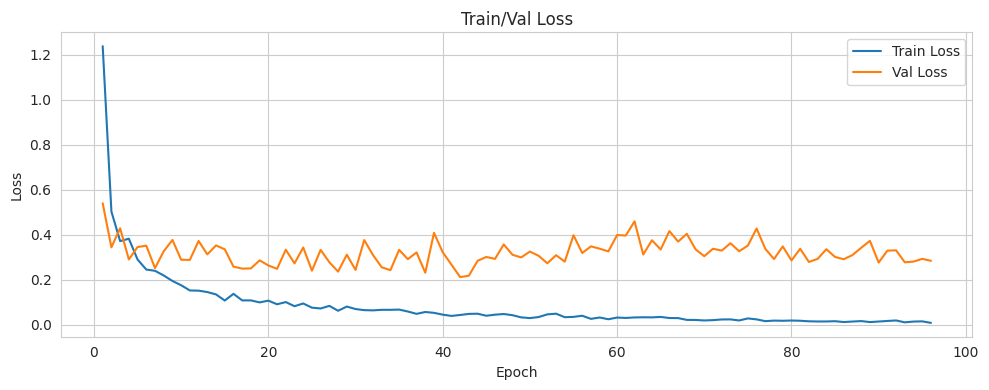

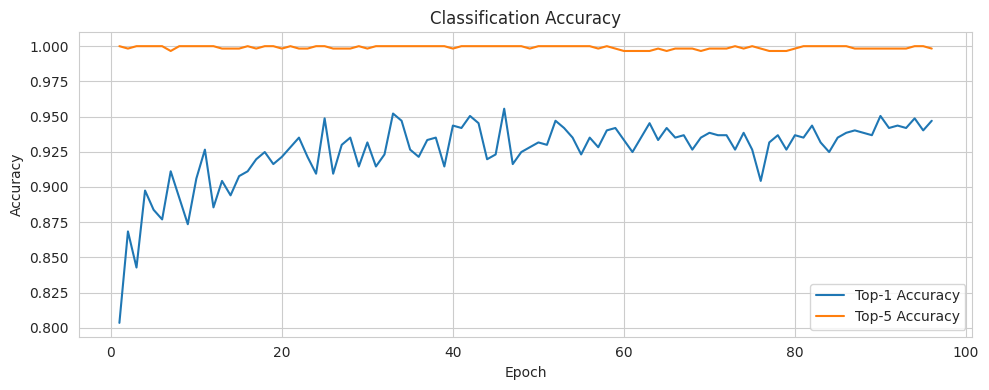

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lấy thư mục chứa kết quả training
metrics_path = Path(trainer.training_results.save_dir) / 'results.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(metrics_path)

# Thiết lập kiểu biểu đồ
sns.set_style("whitegrid")

# Vẽ Loss
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["train/loss"], label="Train Loss")
plt.plot(df["epoch"], df["val/loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Vẽ Accuracy
plt.figure(figsize=(10, 4))
plt.plot(df["epoch"], df["metrics/accuracy_top1"], label="Top-1 Accuracy")
plt.plot(df["epoch"], df["metrics/accuracy_top5"], label="Top-5 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


## Nén mô hình và tải về

In [15]:
import os
import shutil

temp_dir = "/kaggle/temp_output"
os.makedirs(temp_dir, exist_ok=True)

for item in os.listdir("/kaggle/working"):
    src = os.path.join("/kaggle/working", item)
    dst = os.path.join(temp_dir, item)
    if os.path.isdir(src):
        shutil.copytree(src, dst)
    else:
        shutil.copy2(src, dst)


In [17]:
shutil.make_archive("dispatch_monitoring_models", "zip", temp_dir)

from IPython.display import FileLink
print("📦 Hoàn tất nén toàn bộ output. Tải về tại đây:")
FileLink("dispatch_monitoring_models.zip")


📦 Hoàn tất nén toàn bộ output. Tải về tại đây:


/kaggle/working/full_training_output.zip

## test model classfication


image 1/1 /kaggle/input/data-classificate/Classification/dish/not_empty/00000000252000000_frame102300_jpg.rf.f820cc0fbf5b5800c5e1b5ed32510c9f_5_0.jpg: 224x224 dish_not_empty 1.00, dish_empty 0.00, dish_kakigori 0.00, tray_not_empty 0.00, tray_kakigori 0.00, 2.6ms
Speed: 2.7ms preprocess, 2.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


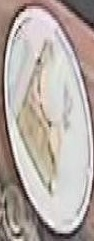

🧠 Predicted Class: dish_not_empty (100.00%)


In [21]:
from ultralytics import YOLO
from PIL import Image
from IPython.display import display

# Load lại model đã huấn luyện
clf_model = YOLO(str(model_path))

# Ảnh cần test
image_path = "/kaggle/input/data-classificate/Classification/dish/not_empty/00000000252000000_frame102300_jpg.rf.f820cc0fbf5b5800c5e1b5ed32510c9f_5_0.jpg"

# Dự đoán
results = clf_model.predict(image_path, imgsz=trainer.image_size)

# Hiển thị ảnh và kết quả
img = Image.open(image_path)
display(img)

# In kết quả dự đoán
for result in results:
    top1 = result.probs.top1
    conf = result.probs.top1conf.item()
    label = result.names[top1]
    print(f"🧠 Predicted Class: {label} ({conf:.2%})")


## Predict video

In [22]:
!pip install -q ultralytics opencv-python

In [23]:
from ultralytics import YOLO
import cv2
import os
from IPython.display import FileLink

# Đường dẫn video
video_input_path = "/kaggle/input/video-to-predict/1473_CH05_20250501133703_154216.mp4"
video_output_path = "/kaggle/working/predicted_video.mp4"

# Đường dẫn mô hình
detection_model_path = "/kaggle/input/model_detect-and-classify/tensorflow2/default/1/models/detection_model_yolov8s_best_100_gpu_27062025.pt"
classification_model_path = "/kaggle/input/model_detect-and-classify/tensorflow2/default/1/models/classification_model_yolov8s-cls_best_100_gpu_28062025.pt"

# Load models
detection_model = YOLO(detection_model_path)
classification_model = YOLO(classification_model_path)


In [24]:
cap = cv2.VideoCapture(video_input_path)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
w, h = int(cap.get(3)), int(cap.get(4))
out = cv2.VideoWriter(video_output_path, fourcc, fps, (w, h))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1

    # Chạy mô hình detection
    results = detection_model.predict(source=frame, save=False, conf=0.25, verbose=False)[0]

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = detection_model.names[int(box.cls[0])]
        conf = float(box.conf[0])

        # Cắt vùng phát hiện để phân loại
        cropped = frame[y1:y2, x1:x2]
        if cropped.shape[0] > 0 and cropped.shape[1] > 0:
            cls_result = classification_model.predict(source=cropped, save=False, verbose=False)[0]
            cls_label = classification_model.names[int(cls_result.probs.top1)]
        else:
            cls_label = "?"

        # Vẽ bounding box và nhãn
        annotated_text = f"{label} ({cls_label}) {conf:.2f}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, annotated_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
print(f"✅ Hoàn tất! Video kết quả đã lưu tại: {video_output_path}")


✅ Hoàn tất! Video kết quả đã lưu tại: /kaggle/working/predicted_video.mp4


In [32]:
import zipfile
from IPython.display import FileLink

# Đường dẫn video đầu ra
video_path = "/kaggle/working/predicted_video.mp4"
zip_path = "predicted_video_only.zip"

# Nén video lại
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write(video_path, arcname="predicted_video.mp4")

# Hiển thị link tải về
print("✅ File đã được nén. Bấm vào link bên dưới để tải về máy tính:")
FileLink(zip_path)


✅ File đã được nén. Bấm vào link bên dưới để tải về máy tính:


/kaggle/working/predicted_video_only.zip